# Анализ влияния LE, PE, OHE кодирования на предсказательную способность anomaly-detection-моделей

- Задача поиска аномалий (unsupervised)
- рассматриваются моделе: OCSVM, IF, EE, LOF
- поля `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `Amount`, `Value`, `PricingStrategy`
- сравниваем результаты LE-кодирования, LE-кодирования со скейлингом, PE-кодирования и OHE

In [1]:
import numpy  as np
import pandas as pd

In [2]:
df_trn = pd.read_csv('../data/training_le.csv')

In [3]:
df_trn.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,36122,3956,886,4405,5,9,0,2,1000.0,1000,2018-11-15 02:18:49,2,0
1,15641,4840,3828,4405,3,5,2,1,-20.0,20,2018-11-15 02:19:08,2,0
2,53940,4228,221,4682,5,0,0,2,500.0,500,2018-11-15 02:44:21,2,0
3,102362,647,2184,987,0,20,9,2,20000.0,21800,2018-11-15 03:32:55,2,0
4,38779,4840,3828,987,3,5,2,1,-644.0,644,2018-11-15 03:34:21,2,0


**Correlation Matrices**

In [4]:
corr = df_trn.corr()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

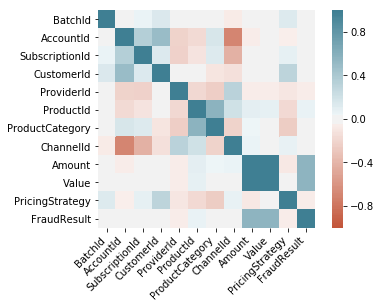

In [6]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [7]:
corr.loc[:, :]

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult
BatchId,1.000000,0.031850,0.060558,0.144860,-0.034058,-0.017532,-0.037846,-0.063891,-0.013423,0.007764,0.131405,-0.000683
AccountId,0.031850,1.000000,0.352973,0.503405,-0.213127,-0.158946,0.171551,-0.694218,-0.048580,-0.035141,-0.039308,-0.026157
SubscriptionId,0.060558,0.352973,1.000000,0.133708,-0.221204,-0.112645,0.118305,-0.423540,-0.036190,-0.011349,0.083328,-0.010864
CustomerId,0.144860,0.503405,0.133708,1.000000,-0.004948,-0.023494,-0.102622,-0.127159,-0.037375,0.011864,0.302477,-0.004549
ProviderId,-0.034058,-0.213127,-0.221204,-0.004948,1.000000,-0.180489,-0.245062,0.323558,-0.049208,-0.062083,-0.095864,-0.051937
ProductId,-0.017532,-0.158946,-0.112645,-0.023494,-0.180489,1.000000,0.577532,0.203787,0.089368,0.082494,-0.179263,0.063452
ProductCategory,-0.037846,0.171551,0.118305,-0.102622,-0.245062,0.577532,1.000000,-0.211960,0.042541,0.033191,-0.255262,0.027165
ChannelId,-0.063891,-0.694218,-0.423540,-0.127159,0.323558,0.203787,-0.211960,1.000000,0.051903,0.028611,0.075672,0.024972
Amount,-0.013423,-0.048580,-0.036190,-0.037375,-0.049208,0.089368,0.042541,0.051903,1.000000,0.989692,-0.079827,0.557370
Value,0.007764,-0.035141,-0.011349,0.011864,-0.062083,0.082494,0.033191,0.028611,0.989692,1.000000,-0.038703,0.566739


## Common preparing

In [8]:
df_trn = pd.read_csv('../data/training_le.csv')
df_tst = pd.read_csv('../data/test_le.csv')

In [10]:
num_transactions = df_trn.shape[0]
num_otliers = df_trn['FraudResult'].value_counts()[1]
num_inliers = df_trn['FraudResult'].value_counts()[0]
outliers_fraction = num_otliers / num_transactions
print('Train outliers fraction:', round(outliers_fraction, 3))

Train outliers fraction: 0.002


In [11]:
y_trn = df_trn['FraudResult']

In [12]:
from collections import Counter
print('Train Label Distribution: {}'.format(Counter(y_trn)))

Train Label Distribution: Counter({0: 95469, 1: 193})


In [13]:
df_trn.tail(5)

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
95657,96667,4840,3828,3077,3,5,2,1,-1000.0,1000,2019-02-13 09:54:09,2,0
95658,3502,3438,2642,3873,5,9,0,2,1000.0,1000,2019-02-13 09:54:25,2,0
95659,118601,4840,3828,3873,3,5,2,1,-20.0,20,2019-02-13 09:54:35,2,0
95660,70923,1345,651,1708,5,18,8,2,3000.0,3000,2019-02-13 10:01:10,2,0
95661,29316,4840,3828,1708,3,5,2,1,-60.0,60,2019-02-13 10:01:28,2,0


In [14]:
df_tst.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,35027,2440,4425,2856,4,2,0,2,1000.0,1000,2019-02-13 10:01:40,3
1,45138,3438,2642,3873,4,14,2,2,2000.0,2000,2019-02-13 10:02:12,2
2,74886,4840,3828,2856,3,5,2,1,-50.0,50,2019-02-13 10:02:30,2
3,11024,2684,4625,3104,4,9,0,2,3000.0,3000,2019-02-13 10:02:38,3
4,29803,4840,3828,3104,3,5,2,1,-60.0,60,2019-02-13 10:02:58,2


In [15]:
columns4drop = [
    'BatchId',
    'AccountId',
    'SubscriptionId',
    'CustomerId',
    'TransactionStartTime'
]

In [16]:
df_trn = df_trn.drop(columns=columns4drop, axis=1)
df_tst = df_tst.drop(columns=columns4drop, axis=1)
print(df_trn.shape, df_tst.shape)

(95662, 8) (45019, 7)


In [17]:
df_trn = df_trn.drop(columns='FraudResult', axis=1)

In [18]:
frames = [df_trn, df_tst]
df_union = pd.concat(frames)
df_union.shape

(140681, 7)

In [19]:
df_union.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,5,9,0,2,1000.0,1000,2
1,3,5,2,1,-20.0,20,2
2,5,0,0,2,500.0,500,2
3,0,20,9,2,20000.0,21800,2
4,3,5,2,1,-644.0,644,2


In [20]:
print('Number of outliers on union dataset =', round(df_union.shape[0]*outliers_fraction, 0))

Number of outliers on union dataset = 284.0


**Scaling**

In [21]:
from sklearn.preprocessing import RobustScaler

In [22]:
def scaleColumns(data, cols_to_scale, scaler):
    for col in cols_to_scale:
        data[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data[col])))
    return data

In [23]:
df_union = scaleColumns(df_union, ['Amount', 'Value'], RobustScaler())

In [24]:
df_union.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,5,9,0,2,0.000000,0.000000,2
1,3,5,2,1,-0.334426,-0.212674,2
2,5,0,0,2,-0.163934,-0.108507,2
3,0,20,9,2,6.229508,4.513889,2
4,3,5,2,1,-0.539016,-0.077257,2


In [25]:
# Anomaly Detection Libraries
from sklearn            import svm
from sklearn.ensemble   import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors  import LocalOutlierFactor

In [26]:
algorithms = {
    'OCSVM': svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.000001),
    'IF   ': IsolationForest(behaviour='new', contamination=outliers_fraction, random_state=24),
    'EE   ': EllipticEnvelope(contamination=outliers_fraction*1.15),
    'LOF  ': LocalOutlierFactor(n_neighbors=12, contamination=outliers_fraction, novelty=True)
}

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = 2\cdot\frac{Precision\cdot{Recall}}{Precision+Recall}$

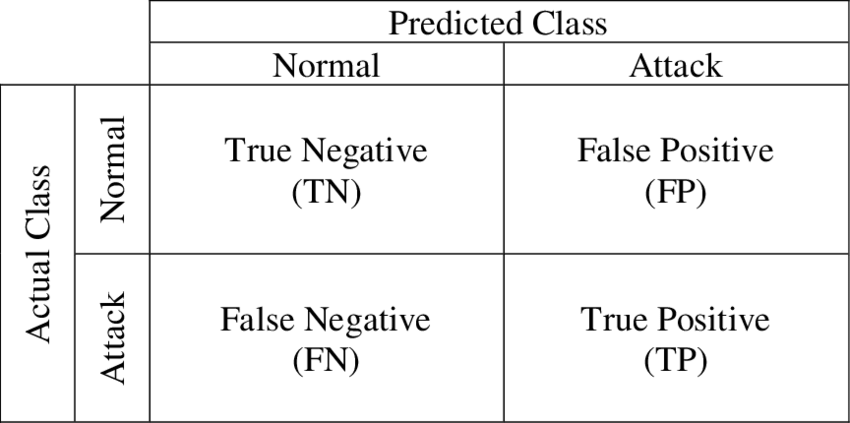

In [55]:
def running_anomaly_detection_methods(X, y_eta_trn):
    print(' '*27, 'Confusion-Matrix')
    print('Algorithm', ' '*20, 'TN       FP')
    print(' '*7, 'Frd_tst   Frd_trn      FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC')
    print('='*110)

    # iterate over classifiers
    for name, algorithm in algorithms.items():
        # fit the data and tag outliers
        if name == 'LOF':
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
            
        y_pred = [ 1 if x == -1 else 0 for x in y_pred ]
        y_pred_trn = y_pred[ : len(y_trn)]
        y_pred_tst = y_pred[len(y_trn) : ]
        
        n_frauds_trn      = Counter(y_pred_trn)[1]
        n_frauds_tst      = Counter(y_pred_tst)[1]
        tn, fp, fn, tp    = confusion_matrix(y_eta_trn, y_pred_trn).ravel()
        precision         = precision_score(y_eta_trn, y_pred_trn)
        recall            = recall_score(y_eta_trn, y_pred_trn)
        f1                = f1_score(y_eta_trn, y_pred_trn)
        kappa             = cohen_kappa_score(y_eta_trn, y_pred_trn)
        balanced_accuracy = balanced_accuracy_score(y_eta_trn, y_pred_trn)
        roc_auc           = roc_auc_score(y_eta_trn, y_pred_trn)
        
        print('%s %8i %8i' % (' '*24, tn, fp))
        print('%s %8i %8i %8i %8i %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f' % 
              (name+' ', n_frauds_tst, n_frauds_trn, fn, tp, precision, recall, f1, kappa, balanced_accuracy, roc_auc))
        
    print('-'*110)
    return

### Only `Amount`

In [30]:
columns4drop = [
    'ProviderId',
    'ProductId',
    'ProductCategory',
    'ChannelId',
    'Value',
    'PricingStrategy',
]

In [31]:
df = df_union.drop(columns=columns4drop, axis=1)

In [32]:
df.head()

,Amount
0,0.000000
1,-0.334426
2,-0.163934
3,6.229508
4,-0.539016


In [56]:
running_anomaly_detection_methods(df, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            95322      147
OCSVM       210       81      130       63     0.3000     0.3264     0.3127     0.3112     0.6624     0.6624
                            95413       56
IF          170       68       79      114     0.6706     0.5907     0.6281     0.6274     0.7950     0.7950
                            95410       59
EE          231       98       21      172     0.7446     0.8912     0.8113     0.8109     0.9453     0.9453
                            95309      160
LOF         191       59      162       31     0.1623     0.1606     0.1615     0.1598     0.5795     0.5795
--------------------------------------------------------------------------------------------------------------


### Only `Amount` and `Value`

In [57]:
columns4drop = [
    'ProviderId',
    'ProductId',
    'ProductCategory',
    'ChannelId',
    'PricingStrategy',
]

In [58]:
df = df_union.drop(columns=columns4drop, axis=1)

In [59]:
df.head()

,Amount,Value
0,0.000000,0.000000
1,-0.334426,-0.212674
2,-0.163934,-0.108507
3,6.229508,4.513889
4,-0.539016,-0.077257


In [60]:
running_anomaly_detection_methods(df, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            95300      169
OCSVM       236       91      126       67     0.2839     0.3472     0.3124     0.3108     0.6727     0.6727
                            95413       56
IF          178       73       71      122     0.6854     0.6321     0.6577     0.6570     0.8158     0.8158
                            95295      174
EE          233       94      134       59     0.2532     0.3057     0.2770     0.2754     0.6519     0.6519
                            95328      141
LOF         172       56      162       31     0.1802     0.1606     0.1699     0.1683     0.5796     0.5796
--------------------------------------------------------------------------------------------------------------


### LE-coding
 of fields: `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `PricingStrategy`

`RobustScaler` of fields: `Amount`, `Value`

In [61]:
df = df_union

In [62]:
df.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,5,9,0,2,0.000000,0.000000,2
1,3,5,2,1,-0.334426,-0.212674,2
2,5,0,0,2,-0.163934,-0.108507,2
3,0,20,9,2,6.229508,4.513889,2
4,3,5,2,1,-0.539016,-0.077257,2


In [63]:
running_anomaly_detection_methods(df, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            95325      144
OCSVM       207       80      130       63     0.3043     0.3264     0.3150     0.3136     0.6625     0.6625
                            95288      181
IF          266       15      108       85     0.3195     0.4404     0.3704     0.3689     0.7193     0.7193
                            95408       61
EE          230       98       24      169     0.7348     0.8756     0.7991     0.7986     0.9375     0.9375
                            95361      108
LOF         113      102      188        5     0.0442     0.0259     0.0327     0.0312     0.5124     0.5124
--------------------------------------------------------------------------------------------------------------


### LE-coding with `MinMaxScaler`
`MinMaxScaler` of fields: `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `PricingStrategy`

`RobustScaler` of fields: `Amount`, `Value`

In [64]:
columns4MinMaxScaler = [
    'ProviderId',
    'ProductId', 
    'ProductCategory', 
    'ChannelId',
    'PricingStrategy'
]

In [65]:
# int --> float
for clm in columns4MinMaxScaler:
    df[clm] = df[clm].astype(float)

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
df = scaleColumns(df, columns4MinMaxScaler, MinMaxScaler())

In [68]:
df.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,1.0,0.346154,0.000000,0.50,0.000000,0.000000,0.666667
1,0.6,0.192308,0.222222,0.25,-0.334426,-0.212674,0.666667
2,1.0,0.000000,0.000000,0.50,-0.163934,-0.108507,0.666667
3,0.0,0.769231,1.000000,0.50,6.229508,4.513889,0.666667
4,0.6,0.192308,0.222222,0.25,-0.539016,-0.077257,0.666667


In [69]:
running_anomaly_detection_methods(df, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            95342      127
OCSVM       190       74      130       63     0.3316     0.3264     0.3290     0.3276     0.6625     0.6625
                            95375       94
IF          168      107      119       74     0.4405     0.3834     0.4100     0.4089     0.6912     0.6912
                            95336      133
EE          234       91       92      101     0.4316     0.5233     0.4731     0.4719     0.7610     0.7610
                            95320      149
LOF         155       68      187        6     0.0387     0.0311     0.0345     0.0327     0.5148     0.5148
--------------------------------------------------------------------------------------------------------------


### PE-coding
PE-coding of fields: `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `PricingStrategy`

`RobustScaler` of fields: `Amount`, `Value`

In [111]:
df_trn = pd.read_csv('../data/training_pe.csv')
df_tst = pd.read_csv('../data/test_pe.csv')

In [112]:
columns4drop = [
    'BatchId',
    'AccountId',
    'SubscriptionId',
    'CustomerId',
    'TransactionStartTime'
]

In [113]:
df_trn = df_trn.drop(columns=columns4drop, axis=1)
df_tst = df_tst.drop(columns=columns4drop, axis=1)
print(df_trn.shape, df_tst.shape)

(95662, 8) (45019, 7)


In [114]:
df_trn = df_trn.drop(columns='FraudResult', axis=1)

In [115]:
frames = [df_trn, df_tst]
df_union = pd.concat(frames)
df_union.shape

(140681, 7)

In [116]:
df_union.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,0.000088,0.000390,0.000400,0.003232,1000.0,1000,0.001741
1,0.000131,0.000031,0.003546,0.000135,-20.0,20,0.001741
2,0.000088,0.000000,0.000400,0.003232,500.0,500,0.001741
3,0.010101,0.002646,0.006250,0.003232,20000.0,21800,0.001741
4,0.000131,0.000031,0.003546,0.000135,-644.0,644,0.001741


**Scaling**

Вычисляем "предсказательную способность" данного значения, то есть угадывает ли он `frauds` и лучше, чем просто среднее

Для этого смотрим как часто этот признак сигнализирует о `frauds` и вычитаем частоту `frauds` во всей выборке

In [117]:
columns4scaling = [
    'ProviderId',
    'ProductId',
    'ProductCategory',
    'ChannelId',
    'PricingStrategy'
]

In [118]:
# coef = n_frauds / (n_frauds + n_nofrauds) 
for clm in columns4scaling:
    df_union[clm] -= outliers_fraction

In [119]:
df = df_union

In [120]:
df.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,-0.001930,-0.001628,-0.001618,0.001214,1000.0,1000,-0.000277
1,-0.001887,-0.001987,0.001528,-0.001883,-20.0,20,-0.000277
2,-0.001930,-0.002018,-0.001618,0.001214,500.0,500,-0.000277
3,0.008083,0.000628,0.004232,0.001214,20000.0,21800,-0.000277
4,-0.001887,-0.001987,0.001528,-0.001883,-644.0,644,-0.000277


In [121]:
running_anomaly_detection_methods(df, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            83640    11829
OCSVM     11925     6048       97       96     0.0081     0.4974     0.0158     0.0119     0.6868     0.6868
                            95363      106
IF          186       98      113       80     0.4301     0.4145     0.4222     0.4210     0.7067     0.7067
                            95410       59
EE           99      228      153       40     0.4040     0.2073     0.2740     0.2730     0.6033     0.6033
                            95329      140
LOF         153       70      180       13     0.0850     0.0674     0.0751     0.0735     0.5329     0.5329
--------------------------------------------------------------------------------------------------------------


**Robust Scale `Amount` and `Value`**

In [122]:
df_rs = df_union

In [123]:
columns4RobustScaler = [
    'Amount',
    'Value'
]

In [124]:
df_rs = scaleColumns(df_rs, columns4RobustScaler, RobustScaler())

In [125]:
df_rs.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,-0.001930,-0.001628,-0.001618,0.001214,0.000000,0.000000,-0.000277
1,-0.001887,-0.001987,0.001528,-0.001883,-0.334426,-0.212674,-0.000277
2,-0.001930,-0.002018,-0.001618,0.001214,-0.163934,-0.108507,-0.000277
3,0.008083,0.000628,0.004232,0.001214,6.229508,4.513889,-0.000277
4,-0.001887,-0.001987,0.001528,-0.001883,-0.539016,-0.077257,-0.000277


In [126]:
running_anomaly_detection_methods(df_rs, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            95300      169
OCSVM       236       91      126       67     0.2839     0.3472     0.3124     0.3108     0.6727     0.6727
                            95300      169
IF          272       16       90      103     0.3787     0.5337     0.4430     0.4417     0.7660     0.7660
                            95372       97
EE          252       74       38      155     0.6151     0.8031     0.6966     0.6959     0.9010     0.9010
                            95283      186
LOF         191       52      188        5     0.0262     0.0259     0.0260     0.0241     0.5120     0.5120
--------------------------------------------------------------------------------------------------------------


**Scandart Scale `Amount` and `Value`**

In [127]:
df_ss = df_union

In [128]:
from sklearn.preprocessing import StandardScaler

In [129]:
columns4StandardScaler = [
    'Amount',
    'Value'
]

In [130]:
df_ss = scaleColumns(df_ss, columns4StandardScaler, StandardScaler())

In [131]:
df_ss.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,-0.001930,-0.001628,-0.001618,0.001214,-0.047967,-0.076872,-0.000277
1,-0.001887,-0.001987,0.001528,-0.001883,-0.057172,-0.085732,-0.000277
2,-0.001930,-0.002018,-0.001618,0.001214,-0.052479,-0.081392,-0.000277
3,0.008083,0.000628,0.004232,0.001214,0.123498,0.111172,-0.000277
4,-0.001887,-0.001987,0.001528,-0.001883,-0.062803,-0.080090,-0.000277


In [132]:
running_anomaly_detection_methods(df_ss, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            71233    24236
OCSVM     24290    12458      139       54     0.0022     0.2798     0.0044     0.0004     0.5130     0.5130
                            95300      169
IF          272       16       90      103     0.3787     0.5337     0.4430     0.4417     0.7660     0.7660
                            95289      180
EE          252       76      121       72     0.2857     0.3731     0.3236     0.3220     0.6856     0.6856
                            95350      119
LOF         124       93      188        5     0.0403     0.0259     0.0315     0.0300     0.5123     0.5123
--------------------------------------------------------------------------------------------------------------


### OHE-coding
- `OHE` of fields: `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `PricingStrategy`
- `RobustScaler` of fields: `Amount`, `Value`

In [133]:
df_trn = pd.read_csv('../data/training_ohe_short.csv')
df_tst = pd.read_csv('../data/test_ohe_short.csv')

In [134]:
columns4drop = [
    'BatchId',
    'AccountId',
    'SubscriptionId',
    'CustomerId',
    'TransactionStartTime'
]

In [135]:
df_trn = df_trn.drop(columns=columns4drop, axis=1)
df_tst = df_tst.drop(columns=columns4drop, axis=1)
print(df_trn.shape, df_tst.shape)

(95662, 55) (45019, 54)


In [136]:
df_trn = df_trn.drop(columns='FraudResult', axis=1)

In [137]:
frames = [df_trn, df_tst]
df_union = pd.concat(frames)
df_union.shape

(140681, 54)

In [138]:
df_union.head()

,Amount,Value,ProviderId_0,ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProductId_0,ProductId_1,...,ProductCategory_9,ChannelId_0,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_3
0,1000.0,1000,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,-20.0,20,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,500.0,500,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,20000.0,21800,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,-644.0,644,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


**Robust Scale `Amount` and `Value`**

In [139]:
df_rs = df_union

In [140]:
columns4RobustScaler = [
    'Amount',
    'Value'
]

In [141]:
df_rs = scaleColumns(df_rs, columns4RobustScaler, RobustScaler())

In [142]:
df_rs.head()

,Amount,Value,ProviderId_0,ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProductId_0,ProductId_1,...,ProductCategory_9,ChannelId_0,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_3
0,0.000000,0.000000,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,-0.334426,-0.212674,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.163934,-0.108507,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,6.229508,4.513889,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,-0.539016,-0.077257,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [143]:
running_anomaly_detection_methods(df_rs, y_trn)

                            Confusion-Matrix
Algorithm                      TN       FP
            Frd_trn   Frd_tst  FN       TP     Precision  Recall     F1-score   kappa      b_accuracy ROC_AUC
                            95300      169
OCSVM       236       91      126       67     0.2839     0.3472     0.3124     0.3108     0.6727     0.6727
                            95272      197
IF          241       29      149       44     0.1826     0.2280     0.2028     0.2010     0.6130     0.6130
                            95354      115
EE          235       92       73      120     0.5106     0.6218     0.5607     0.5598     0.8103     0.8103
                            95390       79
LOF          79       92      193        0     0.0000     0.0000     0.0000    -0.0012     0.4996     0.4996
--------------------------------------------------------------------------------------------------------------
